# Capsnets train + test

First, import stuff

In [7]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)
import data_loader
import model_i2s

## Load word vectors and data

In [2]:
word2vec_path = '../../english_word_vectors/wiki-news-300d-1M.vec'

# No diacritics data
training_data_paths = [
            '../data-capsnets/atis/train.txt'
#         '../data-capsnets/scenario0/train.txt',
#         '../data-capsnets/scenario1/train.txt',
#         '../data-capsnets/scenario2/train.txt',
#         '../data-capsnets/scenario3.1/train.txt',
#         '../data-capsnets/scenario3.2/train.txt',
#         '../data-capsnets/scenario3.3/train.txt',
    ]
test_data_paths = [
      '../data-capsnets/atis/test.txt'
#     '../data-capsnets/scenario0/test.txt',
#     '../data-capsnets/scenario1/test.txt',
#     '../data-capsnets/scenario2/test.txt',
#     '../data-capsnets/scenario3.1/test.txt',
#     '../data-capsnets/scenario3.2/test.txt',
#     '../data-capsnets/scenario3.3/test.txt',
]

# Diacritics data
dia_training_data_paths = [
#         '../data-capsnets/diacritics/scenario0/train.txt',
#         '../data-capsnets/diacritics/scenario1/train.txt',
#         '../data-capsnets/diacritics/scenario2/train.txt',
#         '../data-capsnets/diacritics/scenario31/train.txt',
#         '../data-capsnets/diacritics/scenario32/train.txt',
#         '../data-capsnets/diacritics/scenario33/train.txt',
    ]
dia_test_data_paths = [
#     '../data-capsnets/diacritics/scenario0/test.txt',
#     '../data-capsnets/diacritics/scenario1/test.txt',
#     '../data-capsnets/diacritics/scenario2/test.txt',
#     '../data-capsnets/diacritics/scenario31/test.txt',
#     '../data-capsnets/diacritics/scenario32/test.txt',
#     '../data-capsnets/diacritics/scenario33/test.txt',
]
scenario_nums = [
    
]


In [3]:
print('------------------load word2vec begin-------------------')
w2v = data_loader.load_w2v(word2vec_path)
print('------------------load word2vec end---------------------')

------------------load word2vec begin-------------------
loading time took -213.15
------------------load word2vec end---------------------


In [4]:
data = data_loader.read_datasets(w2v, training_data_paths[0], test_data_paths[0], test=True)

------------------read datasets begin-------------------
Word sfo not in W2V vocabulary!
Word ap68 not in W2V vocabulary!
Word nationair not in W2V vocabulary!
Word o'clock not in W2V vocabulary!
Word stapleton not in W2V vocabulary!
Word o'clock not in W2V vocabulary!
Word o'clock not in W2V vocabulary!
Word dc10 not in W2V vocabulary!
Word o'clock not in W2V vocabulary!
Word ewr not in W2V vocabulary!
Word o'clock not in W2V vocabulary!
Word o'clock not in W2V vocabulary!
Word bwi not in W2V vocabulary!
Word yyz not in W2V vocabulary!
Word bwi not in W2V vocabulary!
Word ewr not in W2V vocabulary!
Word o'clock not in W2V vocabulary!
Word o'clock not in W2V vocabulary!
Word o'clock not in W2V vocabulary!
Word o'clock not in W2V vocabulary!
Word ap80 not in W2V vocabulary!
Word ewr not in W2V vocabulary!
Word o'clock not in W2V vocabulary!
Word bwi not in W2V vocabulary!
Word o'clock not in W2V vocabulary!
Word o'clock not in W2V vocabulary!
Word o'clock not in W2V vocabulary!
Word ewr

------------------read datasets end---------------------


# Train model

First, set the flags

In [10]:
def set_flags(data, scenario):
    FLAGS = tf.app.flags.FLAGS

    tf.app.flags.DEFINE_boolean('save_model', False, 'save model to disk')
    tf.app.flags.DEFINE_string('summaries_dir', './logs', 'tensorboard summaries')
    tf.app.flags.DEFINE_string('ckpt_dir', './saved_models/', 'check point dir')
    tf.app.flags.DEFINE_string('scenario_num', scenario, 'Scenario number')
    tf.app.flags.DEFINE_string('errors_dir', './errors/', 'Errors dir')
    
    vocab_size, word_emb_size = data['embedding'].shape
    _, max_sentence_length = data['x_tr'].shape
    intents_number = len(data['intents_dict'])
    slots_number = len(data['slots_dict'])
    hidden_size = 64

    tf.app.flags.DEFINE_float('keep_prob', 1, 'embedding dropout keep rate for training')
    tf.app.flags.DEFINE_integer('hidden_size', hidden_size, 'embedding vector size')
    tf.app.flags.DEFINE_integer('batch_size', 32, 'batch size')
    tf.app.flags.DEFINE_integer('num_epochs', 20, 'num of epochs')
    tf.app.flags.DEFINE_integer('vocab_size', vocab_size, 'vocab size of word vectors')
    tf.app.flags.DEFINE_integer('max_sentence_length', max_sentence_length, 'max number of words in one sentence')
    tf.app.flags.DEFINE_integer('intents_nr', intents_number, 'intents_number')  #
    tf.app.flags.DEFINE_integer('slots_nr', slots_number, 'slots_number')  #
    tf.app.flags.DEFINE_integer('word_emb_size', word_emb_size, 'embedding size of word vectors')
    tf.app.flags.DEFINE_boolean('use_embedding', True, 'whether to use embedding or not.')
    tf.app.flags.DEFINE_float('learning_rate', 0.01, 'learning rate')
    tf.app.flags.DEFINE_integer('slot_routing_num', 2, 'slot routing num')
    tf.app.flags.DEFINE_integer('intent_routing_num', 3, 'intent routing num')
    tf.app.flags.DEFINE_integer('intent_output_dim', 16, 'intent output dimension')
    tf.app.flags.DEFINE_integer('slot_output_dim', 2 * hidden_size, 'slot output dimension')
    tf.app.flags.DEFINE_integer('d_a', 20, 'self attention weight hidden units number')
    tf.app.flags.DEFINE_integer('r', 5, 'number of self attention heads')
    tf.app.flags.DEFINE_float('alpha', 0.0001, 'coefficient for self attention loss')
    tf.app.flags.DEFINE_integer('n_splits', 3, 'Number of cross-validation splits')
    
    tf.app.flags.DEFINE_string('f', '', 'kernel') # Without this there's an error: unknown command line flag 'f'
    
    return FLAGS

In [9]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)
        
del_all_flags(FLAGS)

In [11]:
import train

FLAGS = set_flags(data, scenario='33-dia-seqmini')
train.train(model_i2s.CapsNetI2S, data, FLAGS)


------------------start cross-validation-------------------
FOLD 1


AttributeError: attention_output_dimenison

# Test

Restoring Variables from Checkpoint for testing
           TEST SET PERFORMANCE        
Intent detection
                          precision    recall  f1-score   support

           aprindeLumina     0.1111    0.1000    0.1053        30
 cresteIntensitateLumina     0.4468    0.7000    0.5455        30
       cresteTemperatura     0.0000    0.0000    0.0000        30
           opresteMuzica     0.1724    0.1667    0.1695        30
               opresteTV     0.3000    0.1000    0.1500        30
              pornesteTV     0.6000    0.5000    0.5455        30
              puneMuzica     0.2400    0.4000    0.3000        30
  scadeIntensitateLumina     0.0000    0.0000    0.0000        30
        scadeTemperatura     0.1667    0.0667    0.0952        30
          schimbaCanalTV     0.2683    0.3667    0.3099        30
schimbaIntensitateMuzica     0.8788    0.9667    0.9206        30
      seteazaTemperatura     0.2449    0.4000    0.3038        30
            stingeLumina     0.0000 

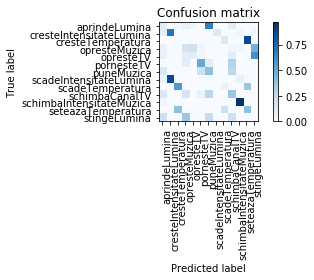

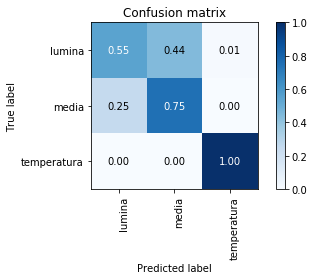

Intent F1: 0.289744
Slot F1: 0.479076


In [73]:
import test
FLAGS = set_flags(data, scenario='33-dia-seqmini')
test.test(model_i2s.CapsNetI2S, data, FLAGS)